In [2]:
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# 1. Load Iris dataset
iris = load_iris()
X = iris.data                     # shape (150, 4)
y = iris.target                   # labels: 0, 1, 2

# 2. Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)  # IMPORTANT: labels must be `long` for CrossEntropyLoss

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Wrap in DataLoader
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)


In [3]:
class IrisClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 8)    # 4 input features → 8 hidden
        self.fc2 = nn.Linear(8, 3)    # 8 hidden → 3 class scores

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # raw scores (logits)


In [4]:
model = IrisClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
train_accuracies = []

for epoch in range(50):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for xb, yb in train_loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        predicted = torch.argmax(preds, dim=1)
        total_correct += (predicted == yb).sum().item()
        total_samples += yb.size(0)
        total_loss += loss.item()

    accuracy = total_correct / total_samples
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} - Loss: {total_loss:.4f} - Accuracy: {accuracy:.4f}")


Epoch 10 - Loss: 2.1534 - Accuracy: 0.9000
Epoch 20 - Loss: 1.1288 - Accuracy: 0.9667
Epoch 30 - Loss: 0.7288 - Accuracy: 0.9583
Epoch 40 - Loss: 0.6286 - Accuracy: 0.9667
Epoch 50 - Loss: 0.5838 - Accuracy: 0.9583


In [5]:
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for xb, yb in test_loader:
        preds = model(xb)
        predicted = torch.argmax(preds, dim=1)
        total_correct += (predicted == yb).sum().item()
        total_samples += yb.size(0)

    test_accuracy = total_correct / total_samples
    print(f"\nTest Accuracy: {test_accuracy:.4f}")



Test Accuracy: 1.0000


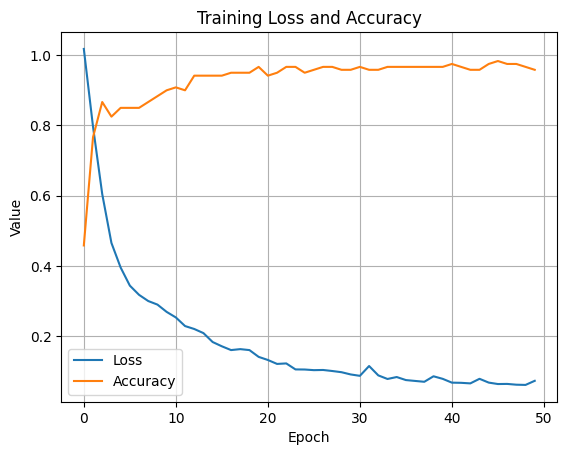

In [6]:
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()
